## Prediction of Stroke from Historic Medical Data

- The objective of this project is to train a machine learning model to predict if the patient has or has the potential to suffer a Stroke or not using their existing records medical records.
- The dataset which was gotten from Kaggle datasets is the medical records of 5110 in India and will be used to train and test our model.
- The test labels for this project is binary {0, 1} which represents categories {yes, no} hence we will be training a Logistic Regression model.

In [1]:
# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
import warnings 
%matplotlib inline
warnings.filterwarnings('ignore')
sb.set_style('darkgrid')


# Load the dataset into a Pandas DataFrame
data = pd.read_csv("stroke-data.csv")

In [2]:
#View a sample of the dataset
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
#View essential information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
#Check the dataset for null or missing values
data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### DATA CLEANING
Our dataset contains some null values and other inconsistencies which we need to clean before proceeding with our analysis and model training. The following issues will be handled.
- Remove rows containing null values
- Change the data type for the Age column to integers
- The datasets captures records for 'Children' hence we will remove all records for children.
- Remove any records where the Age is less than 18 years as the chances of people below having stroke is quite low and hence not a good feature.
- Remove records where the BMI value is considered to be an outlier i.e. BMI is greater than 65.
- Remove 'ID' column as we do not need it for our prediction and its not a feature
- The gender faeture contains a single entry for 'Other' hence we will remove it.

In [5]:
#remove records containing missing values
data.dropna(inplace=True)

data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [6]:
#Confirm that the null values have been removed
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4909 non-null   int64  
 1   gender             4909 non-null   object 
 2   age                4909 non-null   float64
 3   hypertension       4909 non-null   int64  
 4   heart_disease      4909 non-null   int64  
 5   ever_married       4909 non-null   object 
 6   work_type          4909 non-null   object 
 7   Residence_type     4909 non-null   object 
 8   avg_glucose_level  4909 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     4909 non-null   object 
 11  stroke             4909 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 498.6+ KB


In [7]:
#Change the data type for age to Integer instead of float
data['age'] = data['age'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4909 non-null   int64  
 1   gender             4909 non-null   object 
 2   age                4909 non-null   int32  
 3   hypertension       4909 non-null   int64  
 4   heart_disease      4909 non-null   int64  
 5   ever_married       4909 non-null   object 
 6   work_type          4909 non-null   object 
 7   Residence_type     4909 non-null   object 
 8   avg_glucose_level  4909 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     4909 non-null   object 
 11  stroke             4909 non-null   int64  
dtypes: float64(2), int32(1), int64(4), object(5)
memory usage: 479.4+ KB


In [8]:
#Retrieve significant statistical information on the dataset
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,37064.313506,42.854145,0.091872,0.049501,105.305150,28.893237,0.042575
std,20995.098457,22.575986,0.288875,0.216934,44.424341,7.854067,0.201917
min,77.000000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,18605.000000,25.000000,0.000000,0.000000,77.070000,23.500000,0.000000
50%,37608.000000,44.000000,0.000000,0.000000,91.680000,28.100000,0.000000
75%,55220.000000,60.000000,0.000000,0.000000,113.570000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


- From the statistics above we can see that the max and min values for BMI seem to be unrealistic hence we review the values within the min and max corridors to understand the data

In [9]:
#review the bmi data to see the values that fall below 13 and those above 65 which would be rare values for bmi
data[(data['bmi'] < 13) | (data['bmi'] > 65 )]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
544,545,Male,42,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0
657,20364,Female,4,0,0,No,children,Urban,107.25,12.0,Unknown,0
922,45893,Female,8,0,0,No,children,Urban,106.51,12.3,Unknown,0
928,41097,Female,23,1,0,No,Private,Urban,70.03,78.0,smokes,0
1559,37759,Female,53,0,0,Yes,Private,Rural,72.63,66.8,Unknown,0
1609,38043,Female,1,0,0,No,children,Rural,122.04,10.3,Unknown,0
2128,56420,Male,17,1,0,No,Private,Rural,61.67,97.6,Unknown,0
2187,59993,Male,40,0,0,Yes,Private,Rural,60.96,11.5,never smoked,0
3307,3205,Female,79,0,0,Yes,Self-employed,Urban,79.03,11.3,Unknown,0
3319,53924,Female,1,0,0,No,children,Urban,159.39,12.8,Unknown,0


In [10]:
#remove all records categorized as 'Children', records where the age is below 18 and records where the bmi is not above 65
data = data[(data['work_type'] != 'children')]
data = data[(data['bmi'] < 65 )]
data = data[(data['age'] > 17 )]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4069 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4069 non-null   int64  
 1   gender             4069 non-null   object 
 2   age                4069 non-null   int32  
 3   hypertension       4069 non-null   int64  
 4   heart_disease      4069 non-null   int64  
 5   ever_married       4069 non-null   object 
 6   work_type          4069 non-null   object 
 7   Residence_type     4069 non-null   object 
 8   avg_glucose_level  4069 non-null   float64
 9   bmi                4069 non-null   float64
 10  smoking_status     4069 non-null   object 
 11  stroke             4069 non-null   int64  
dtypes: float64(2), int32(1), int64(4), object(5)
memory usage: 397.4+ KB


In [11]:
#Check the classifications in the gender column
data.gender.value_counts()

Female    2486
Male      1582
Other        1
Name: gender, dtype: int64

In [12]:
#Find the row that has the single value for 'Other' and remove it together with the 'Id column' which we dont need
other_index = data.index[data['gender'] == 'Other'].tolist()[0]
data.drop(other_index, axis=0, inplace=True)
data.drop('id', axis=1, inplace=True)

In [13]:
#Confirm the dataset size after cleaning the data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4068 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4068 non-null   object 
 1   age                4068 non-null   int32  
 2   hypertension       4068 non-null   int64  
 3   heart_disease      4068 non-null   int64  
 4   ever_married       4068 non-null   object 
 5   work_type          4068 non-null   object 
 6   Residence_type     4068 non-null   object 
 7   avg_glucose_level  4068 non-null   float64
 8   bmi                4068 non-null   float64
 9   smoking_status     4068 non-null   object 
 10  stroke             4068 non-null   int64  
dtypes: float64(2), int32(1), int64(3), object(5)
memory usage: 365.5+ KB


### EXPLORATORY DATA ANALYSIS
- This section will be used to explore the dataset with the aim of deriving useful insight that will help us in understanding the relationships between the features in our dataset and the label we are trying to predict using our model. 
- This section will also help us understand the type of model we need to build and also the best features from the dataset which we can employ in training our model.

### Univariate Analysis

**1. Review the Age, Glucose Levels and BMI of the patients**

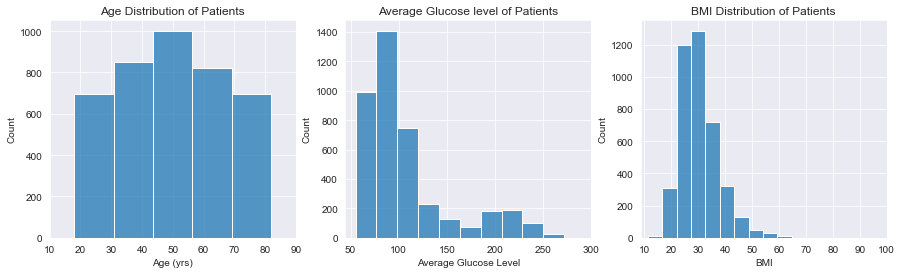

In [14]:
plt.figure(figsize=(15, 4))

plt.subplot(131)
sb.histplot(data.age, bins=5)
plt.xlim([10, 90])
plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.xticks(np.arange(10, 91, 10))
plt.title('Age Distribution of Patients');

plt.subplot(132)
sb.histplot(data.avg_glucose_level, bins=10)
plt.xlabel('Average Glucose Level')
plt.ylabel('Count')
plt.xticks(np.arange(50, 301, 50))
plt.title('Average Glucose level of Patients');

plt.subplot(133)
sb.histplot(data.bmi, bins=10)
plt.xlabel('BMI')
plt.ylabel('Count')
plt.xticks(np.arange(10, 101, 10))
plt.title('BMI Distribution of Patients');

#### Insights
- The majority of the patients are aged 44 - 56 years and more that 60% of the patients were under 60 years of age.
- The glucose levels for most of the patients was normal at values below 100.
- The Bmi profile of the patients show that most of the patients (over 80%) had bmi above 22 which implies that they were mostly obese which is one of the factors that could lead to stroke.

**2. Determine the number of patients who have Stroke, Heart Disease and Hypertension where [0 = No, 1 = Yes]**

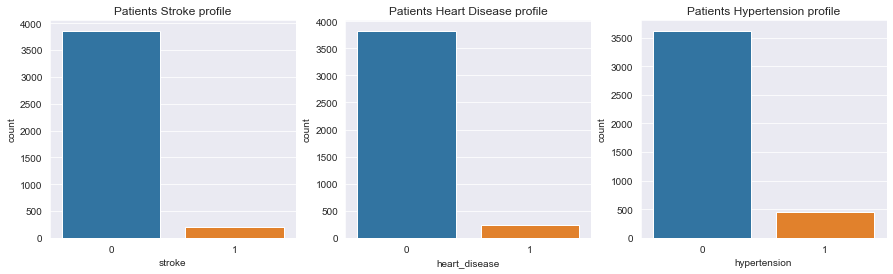

In [15]:
fig = plt.figure(figsize=(15,4))

fig.add_subplot(131)
sb.countplot(x=data.stroke)
plt.title('Patients Stroke profile');

fig.add_subplot(132)
sb.countplot(x=data.heart_disease);
plt.title('Patients Heart Disease profile');

fig.add_subplot(133)
sb.countplot(x=data.hypertension);
plt.title('Patients Hypertension profile');

#### Insights
- The dataset contains very little patients who actually have stroke as we can see from the plot that the number of patients who have been diagnosed with stroke is less than 200. The occurence of heart disease in the patients follows a similar pattern which could imply that their could be relationship.
- Almost 500 of the patients have hypertension and it could be possible that the patients who have stroke could be a subset of the patients with hypertension. What we can confirm from the plot is that all the patients who have hypertension do not have stroke.

### Bivariate Analysis

**1. Confirm the gender distribution of the patients who have stroke, heart disease and hypertension where [0 = No, 1 = Yes]**

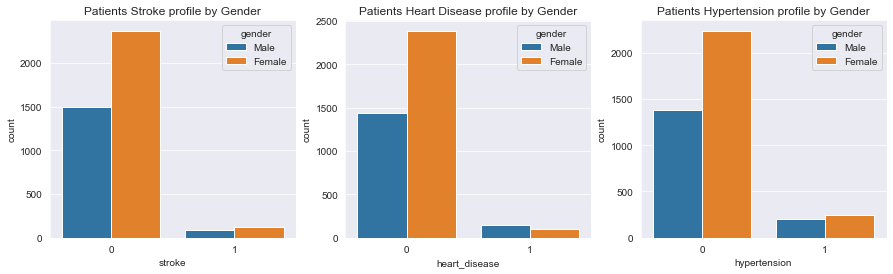

In [16]:
fig = plt.figure(figsize=(15,4))

fig.add_subplot(131)
sb.countplot(x=data.stroke, hue=data.gender)
plt.title('Patients Stroke profile by Gender');

fig.add_subplot(132)
sb.countplot(x=data.heart_disease, hue=data.gender);
plt.title('Patients Heart Disease profile by Gender');

fig.add_subplot(133)
sb.countplot(x=data.hypertension, hue=data.gender);
plt.title('Patients Hypertension profile by Gender');

#### Insights
- The datasets seems to have a higher Female population than Males.
- More females have hypertension and stroke than males however more males suffer from heart disease.

**2. Confirm the distribution of Stroke patients among other Categories in the dataset except Gender**

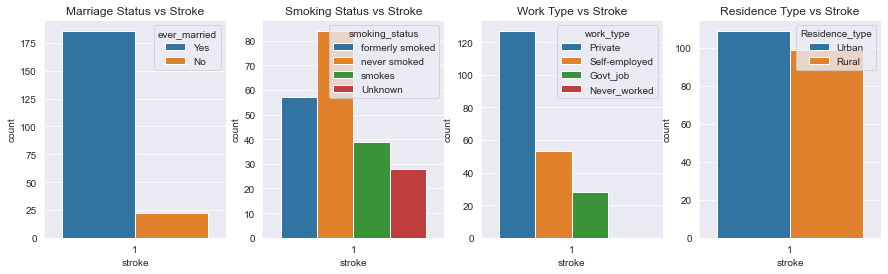

In [17]:
fig = plt.figure(figsize=(15,4))

fig.add_subplot(141)
sb.countplot(x=data.stroke[data['stroke'] == 1], hue=data.ever_married)
plt.title('Marriage Status vs Stroke');

fig.add_subplot(142)
sb.countplot(x=data.stroke[data['stroke'] == 1], hue=data.smoking_status);
plt.title('Smoking Status vs Stroke');

fig.add_subplot(143)
sb.countplot(x=data.stroke[data['stroke'] == 1], hue=data.work_type);
plt.title('Work Type vs Stroke');

fig.add_subplot(144)
sb.countplot(x=data.stroke[data['stroke'] == 1], hue=data.Residence_type);
plt.title('Residence Type vs Stroke');

#### Insights
- The patients who were ever married suffered more from stroke and suprisingly the patients who have never smoked suffered more from stroke. 
- Patients working private jobs had the highest percentage of the total stroke patients which can be related with the stress and pressure of running private businesses and the corresponding risks involved. 
- While the margins are slim, the patients who resided in the urban areas had suffered stroke more than those in the rural areas.

### Multivariate Analysis

**1. Compare the relationship between multiple features**

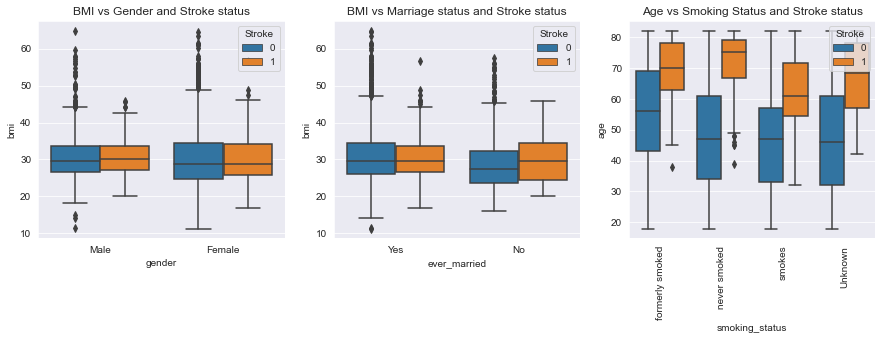

In [18]:
plt.figure(figsize=(15,4))

plt.subplot(131)
sb.boxplot(y=data.bmi, x=data.gender, hue=data.stroke);
plt.legend(title='Stroke', loc=1)
plt.title('BMI vs Gender and Stroke status');

plt.subplot(132)
sb.boxplot(y=data.bmi, x=data.ever_married, hue=data.stroke);
plt.legend(title='Stroke', loc=1);
plt.title('BMI vs Marriage status and Stroke status');


plt.subplot(133)
sb.boxplot(y=data.age, x=data.smoking_status, hue=data.stroke);
plt.legend(title='Stroke', loc=1);
plt.title('Age vs Smoking Status and Stroke status');
plt.xticks(rotation=90);

#### Insights
- The male and female patients who had stroke were mostly obese as most of them had bmi values above 25 and mean bmi for males with stroke is 30 while for females it is slightly lower at 28. Obesity which is characterised by Bmi obviously has some relationship to the chances of having stroke.
- All the patients who had stroke were aged 32 or above while majority of the patients were within the age bracket of 55 - 80 years. The mean age for the patients who had never smoked is 76 years while for those who had smoked formerly it's 70 years hence it does not seem that the stroke would have been related to their smoking habits.

**2. Check if there is linear relationship between our features and label**

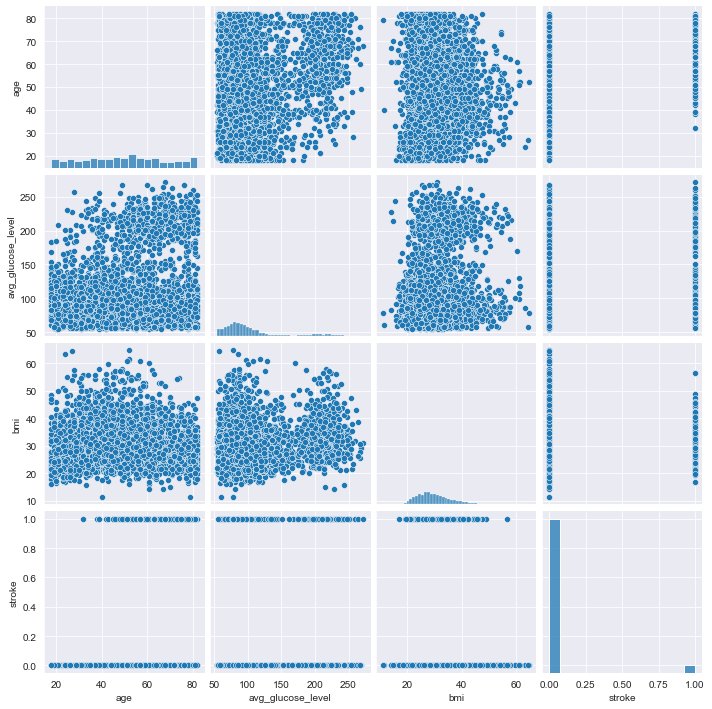

In [19]:
sb.pairplot(data.drop(['hypertension', 'heart_disease'], axis=1));

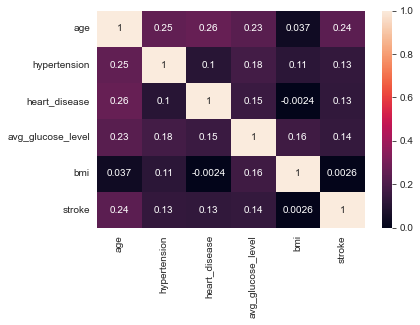

In [20]:
sb.heatmap(data.corr(), annot=True);

#### Insights
- The pairplot does not show any linear relationships between our feature and labels and also the heatmap does not show and tangible correlations between the features and the label or even among the features. 
- The relationship observed between our label and Age, Glocuse level and Bmi is binary which suggests a classification.
- We can conclude from this that our model should not be a linear model rather a classification model hence we proceed with our proposed model.

### CONSIDERATION OF REINFORCEMENT LEARNING
**Reinforcement learning is not suitable for the model we are trying to build based on the following reasons**
- The model we are building is a supervised learning model and the dataset also contains labeled data whereas reinforcement leraning is not a supervised learning algorithm.
- Reinforcement learning determines the best action by it self and follows a reward system however for this task, the outcome is already known, the model is expected to learn those outcomes. 

## Model Building, Training and Prediction

- Our dataset contains some categorical values which has to be transformed to numerical in order to be useful in training our model.

In [21]:
# Define the dictionaries for each categorical column
gender_dict = {'Male': 0, 'Female': 1}
ever_married_dict = {'No': 0, 'Yes': 1}
work_type_dict = {'Never_worked': 0, 'Govt_job': 1, 'Private': 2, 'Self-employed': 3}
residence_type_dict = {'Rural': 0, 'Urban': 1}
smoking_status_dict = {'Unknown': 0, 'never smoked': 1, 'formerly smoked':2, 'smokes': 3}

# Replace the values in each categorical column with the corresponding numerical values
data['gender'] = data['gender'].replace(gender_dict)
data['ever_married'] = data['ever_married'].replace(ever_married_dict)
data['work_type'] = data['work_type'].replace(work_type_dict)
data['Residence_type'] = data['Residence_type'].replace(residence_type_dict)
data['smoking_status'] = data['smoking_status'].replace(smoking_status_dict)

In [23]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67,0,1,1,2,1,228.69,36.6,2,1
2,0,80,0,1,1,2,0,105.92,32.5,1,1
3,1,49,0,0,1,2,1,171.23,34.4,3,1
4,1,79,1,0,1,3,0,174.12,24.0,1,1
5,0,81,0,0,1,2,1,186.21,29.0,2,1


In [42]:
# Extract the features and label from the DataFrame
X = data.iloc[:, 0:-1]
y = data.iloc[:, -1]

In [43]:
print(f'The features have a shape of {X.shape}, while the label has a shape of {y.shape}')

The features have a shape of (4068, 10), while the label has a shape of (4068,)


### Model 1

In [44]:
# Split the data into training and testing sets with a validation split of 30%
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=0)

In [45]:
# Create a logistic regression model
model1 = make_pipeline(StandardScaler(), LogisticRegression())

# Fit the model on the training data
model1.fit(train_x, train_y)

# Evaluate the model on the test data
score = model1.score(test_x, test_y)

# Print the model accuracy
print(f"Model score: {score*100:.2f}%")

# Make predictions on the test data using the trained model
y_predict = model1.predict(test_x)

# Generate the classification report
print('\nClassification Report')
print(classification_report(test_y, y_predict))

Model score: 94.84%

Classification Report
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1157
           1       1.00      0.02      0.03        64

    accuracy                           0.95      1221
   macro avg       0.97      0.51      0.50      1221
weighted avg       0.95      0.95      0.92      1221



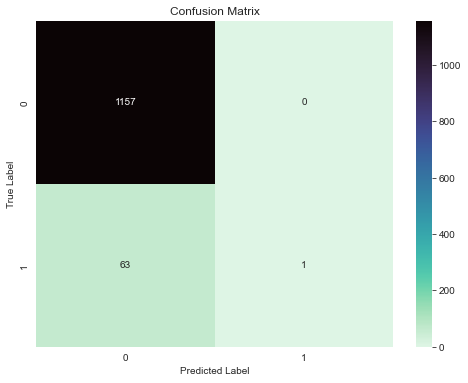

In [46]:
fig = plt.subplots(figsize=(8, 6))

ax = sb.heatmap(confusion_matrix(test_y, y_predict), annot=True, fmt='', xticklabels=['0', '1'], yticklabels=['0', '1'], cmap='mako_r')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix');

### Model 1 Analysis
- From the classification report it is obvious that this model is only predicting one class out of our two classes with class(1) having a score of almost 0 accross recall and f1-score.

In [47]:
#Confirm if our data is balanced or imbalanced
y.value_counts()

0    3860
1     208
Name: stroke, dtype: int64

- The data is clearly imbalanced as the class of '0' is more than 90% of entire data while class '1' is the minority class.
- We have to oversample the minority class to balance our data to ensure that our model is not overfitting or biased.

- **We will create a 2nd model with resampled data to see the impact of the resampling**

### Model 2 (with resampling)

In [62]:
# Split the data into training and testing sets with a validation split of 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

In [71]:
#oversample the minority class in our dataset to create a balance
smote = SMOTE(random_state=50)

In [133]:
# Create a logistic regression model
model = make_pipeline_imb(smote, StandardScaler(), LogisticRegression())

# Fit the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the test data
score = model.score(X_test, y_test)

# Print the model accuracy
print(f"Model score: {score*100:.2f}%")

# Make predictions on the test data using the trained model
y_pred = model.predict(X_test)

# Generate the classification report
print('\nClassification Report')
print(classification_report(y_test, y_pred))

Model score: 78.54%

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      1158
           1       0.13      0.56      0.21        63

    accuracy                           0.79      1221
   macro avg       0.55      0.68      0.54      1221
weighted avg       0.93      0.79      0.84      1221



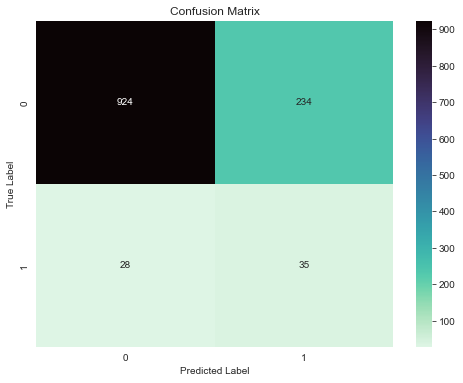

In [52]:
fig = plt.subplots(figsize=(8, 6))

ax = sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='', xticklabels=['0', '1'], yticklabels=['0', '1'], cmap='mako_r')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label');
ax.set_title('Confusion Matrix');

### Model 2 Analysis


- This model without with resampling achieves an accuracy score of 78.54%.
- From recall we can see the proportion of relevant instances of each class that were correctly identified by the model {'0' : 0.80 , '1': 0.56}.
- From the precision score we can see the proportion of predicted positive instances that are actually positive {'0' : 0.97 , '1': 0.13}.
- The f1-score which is a weighted average of precision and recall shows that our class 0 is at 0.21 which is still low but better than the previous score of 0.03 from model 1.
- Overall, we would adopt this second model which is predicting both classes better.

## Futher Implementation for model comparison

## Random Forest implementation (with resampling)

- **We want to try a different model on the resampled data to compare the performance of the models. For this we would use the Random Forest Classifier.**

In [73]:
from sklearn.ensemble import RandomForestClassifier

In [120]:
# Create a logistic random forest model
model_r = make_pipeline_imb(smote, StandardScaler(), RandomForestClassifier(random_state=0, class_weight={0: 1, 1: 3}))

# Fit the model on the training data
model_r.fit(X_train, y_train)

# Evaluate the model on the test data
score_r = model_r.score(X_test, y_test)

# Print the model accuracy
print(f"Model accuracy: {score_r*100:.2f}%")

# Make predictions on the test data using the trained model
y_prediction = model_r.predict(X_test)

# Generate the classification report
print('\nClassification Report')
print(classification_report(y_test, y_prediction))

Model accuracy: 89.19%

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1158
           1       0.13      0.19      0.15        63

    accuracy                           0.89      1221
   macro avg       0.54      0.56      0.55      1221
weighted avg       0.91      0.89      0.90      1221



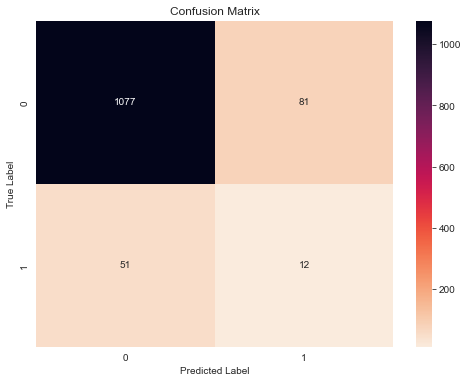

In [121]:
fig = plt.subplots(figsize=(8, 6))

ax = sb.heatmap(confusion_matrix(y_test, y_prediction), annot=True, fmt='', xticklabels=['0', '1'], yticklabels=['0', '1'], cmap='rocket_r')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label');
ax.set_title('Confusion Matrix');

## Summary
- Comparing both models trained using the resampled data, we can see that the Random Forest model (89%) has better prediction accuracy than the Logistic Regression model (78%) on the test data.

### References
- https://www.calculator.net/anorexic-bmi-calculator.html?ctype=metric&cage=32&csex=f&cheightfeet=5&cheightinch=10&cpound=160&cheightmeter=175&ckg=75&x=111&y=22

- https://www.kaggle.com/code/sprakshith/stroke-prediction-beginner-s-guide/notebook
- https://www.cdc.gov/stroke/risk_factors.htm
